In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

In [3]:
n_samples, n_features = X.shape
print(n_samples, n_features)

10000 2


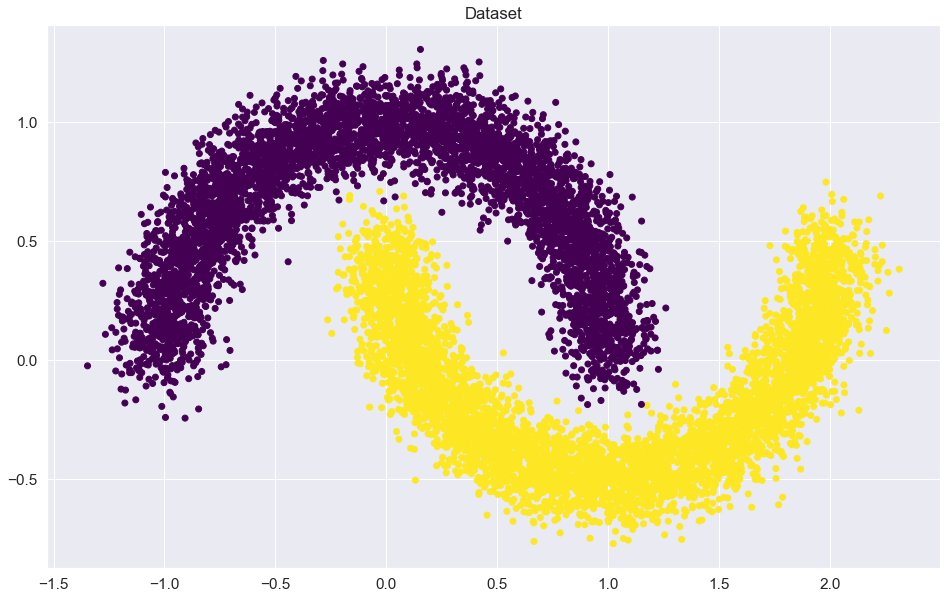

In [4]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [148]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [149]:
#scale X data

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

In [150]:
X_train_t =  torch.from_numpy(X_train.astype(np.float32))
y_train_t =  torch.from_numpy(y_train.astype(np.float32))
X_val_t =  torch.from_numpy(X_val.astype(np.float32))
y_val_t =  torch.from_numpy(y_val.astype(np.float32))

In [151]:
y_train_t = y_train_t.view(y_train_t.shape[0],1)

#make column from row

In [152]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [153]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x =  x@self.weights
        if self.bias:
            x += self.bias_term
        return x

In [161]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

У модели linear_regression 3 обучаемых параметра:  веса w1 и w2 и смещение b

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [162]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch) # YOUR CODE. Use linear_regression to get outputs
        loss =  loss_function(outp, y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 65.0625
Iteration: 100
Batch accuracy: 64.21875
Iteration: 200
Batch accuracy: 63.953125
Iteration: 300
Batch accuracy: 64.46875

Iteration: 373.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 373

### Визуализируем результаты

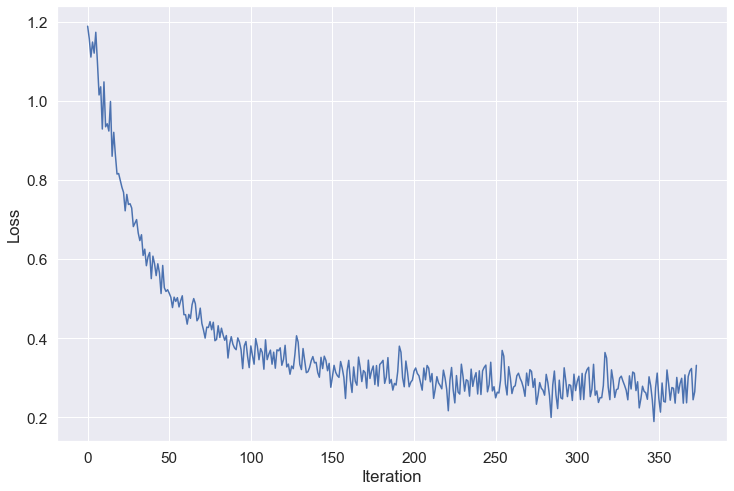

In [163]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

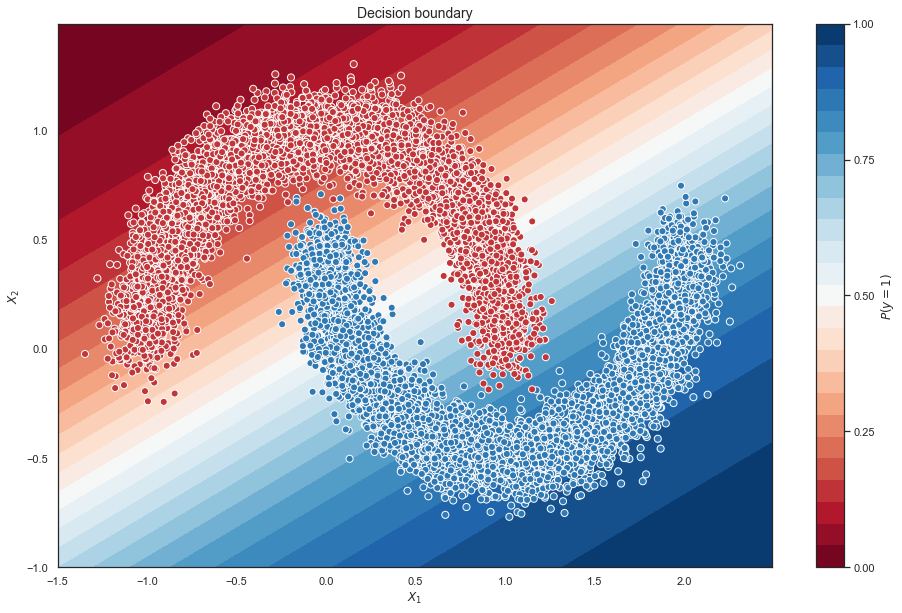

In [164]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [165]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = torch.sigmoid(model(x_batch)).round()
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [166]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val_t, predict(val_dataloader,linear_regression))

0.8945

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.89

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [167]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=4,
                                          shuffle=True, num_workers=2)
valid_dataloader =  DataLoader(val_dataset, batch_size=4,
                                         shuffle=False, num_workers=2)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [168]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [169]:
activation = nn.ELU()

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,128),
    activation,
    nn.Linear(128,128),
    activation,
    nn.Linear(128,10)
)

In [170]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [171]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [172]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
                # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
            preds = outp.argmax(-1)
            correct =  (preds == y_batch).float().sum()  #YOUR CODE GOES HERE
            all =  len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
                # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9095166666666666
Loader: valid. Accuracy: 0.9334
Epoch: 2
Loader: train. Accuracy: 0.9466333333333333
Loader: valid. Accuracy: 0.9386
Epoch: 3
Loader: train. Accuracy: 0.9559333333333333
Loader: valid. Accuracy: 0.9566
Epoch: 4
Loader: train. Accuracy: 0.9589166666666666
Loader: valid. Accuracy: 0.959
Epoch: 5
Loader: train. Accuracy: 0.9636166666666667
Loader: valid. Accuracy: 0.9627
Epoch: 6
Loader: train. Accuracy: 0.9658
Loader: valid. Accuracy: 0.9616
Epoch: 7
Loader: train. Accuracy: 0.96745
Loader: valid. Accuracy: 0.9638
Epoch: 8
Loader: train. Accuracy: 0.96775
Loader: valid. Accuracy: 0.9589
Epoch: 9
Loader: train. Accuracy: 0.9705166666666667
Loader: valid. Accuracy: 0.949
Epoch: 10
Loader: train. Accuracy: 0.9710666666666666
Loader: valid. Accuracy: 0.9697


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [173]:
elu_accuracy = accuracy["valid"]

In [174]:
elu_accuracy

[0.9334, 0.9386, 0.9566, 0.959, 0.9627, 0.9616, 0.9638, 0.9589, 0.949, 0.9697]

In [175]:
def test_activation_function(activation):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784,128),
        activation(),
        nn.Linear(128,128),
        activation(),
        nn.Linear(128,10)
    )
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    loaders = {"train": train_dataloader, "valid": valid_dataloader}
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                preds = outp.argmax(-1)
                correct =  (preds == y_batch).float().sum() 
                all =  len(y_batch)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy["valid"]

In [176]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

Epoch: 1
Loader: train. Accuracy: 0.84855
Loader: valid. Accuracy: 0.8923
Epoch: 2
Loader: train. Accuracy: 0.88265
Loader: valid. Accuracy: 0.9032
Epoch: 3
Loader: train. Accuracy: 0.8895166666666666
Loader: valid. Accuracy: 0.9014
Epoch: 4
Loader: train. Accuracy: 0.89335
Loader: valid. Accuracy: 0.8933
Epoch: 5
Loader: train. Accuracy: 0.8957333333333334
Loader: valid. Accuracy: 0.8904
Epoch: 6
Loader: train. Accuracy: 0.8968833333333334
Loader: valid. Accuracy: 0.883
Epoch: 7
Loader: train. Accuracy: 0.8995666666666666
Loader: valid. Accuracy: 0.9025
Epoch: 8
Loader: train. Accuracy: 0.9011166666666667
Loader: valid. Accuracy: 0.8928
Epoch: 9
Loader: train. Accuracy: 0.9015666666666666
Loader: valid. Accuracy: 0.9068
Epoch: 10
Loader: train. Accuracy: 0.9016333333333333
Loader: valid. Accuracy: 0.9108
Epoch: 1
Loader: train. Accuracy: 0.9042166666666667
Loader: valid. Accuracy: 0.9431
Epoch: 2
Loader: train. Accuracy: 0.9438833333333333
Loader: valid. Accuracy: 0.9444
Epoch: 3
Load

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

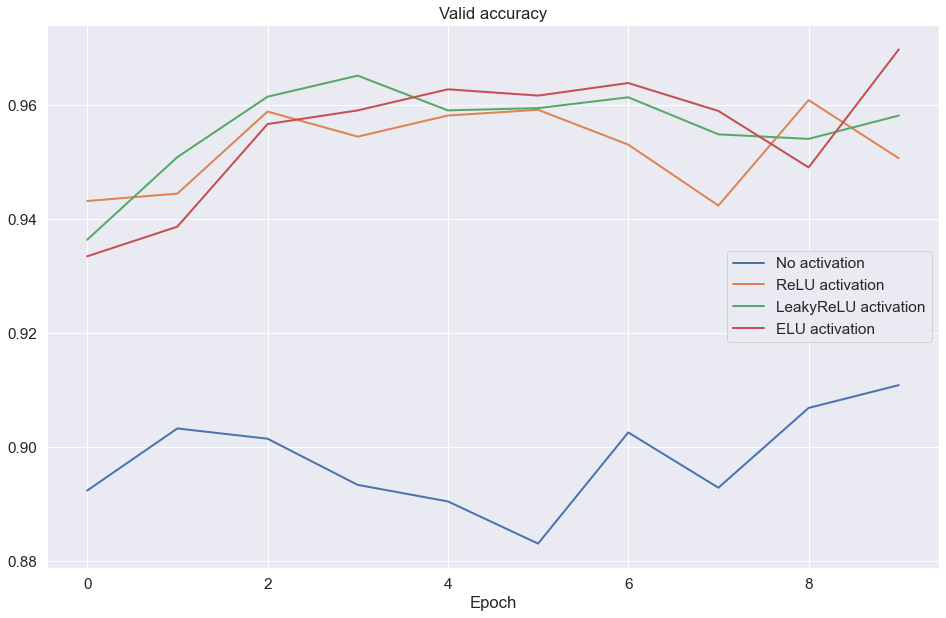

In [178]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [181]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg --no-check-certificate;

�������������: wget [�����]... [URL]...

SYSTEM_WGETRC = c:/progra~1/wget/etc/wgetrc
syswgetrc = C:\Program Files (x86)\GnuWin32/etc/wgetrc
wget: unrecognised option `--no-check-certificate;'




���������� `wget --help' ��� ��������� ������ �����.


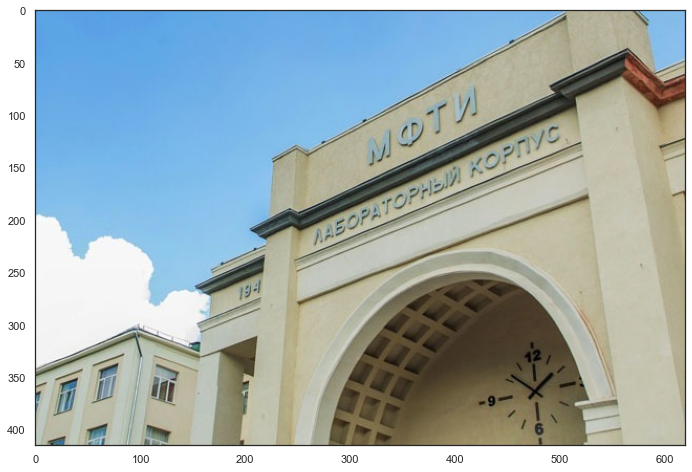

In [182]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [183]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

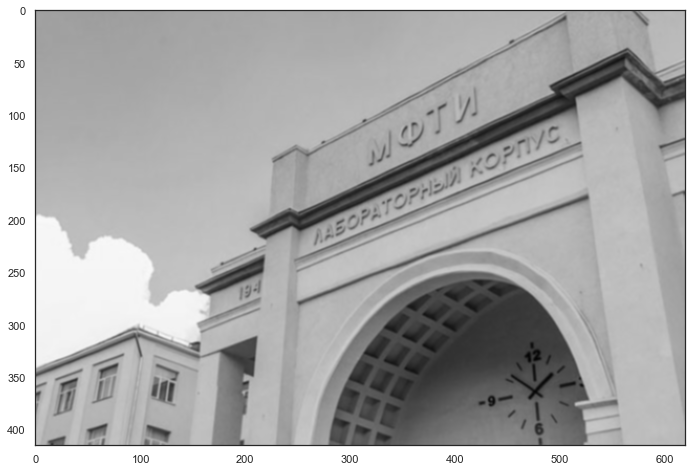

In [184]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

**Ответ:**
1) Размытие -- Е

2) Увеличение резкости -- Д

3) Тождественное преобразование -- А

4) Выделение вертикальных границ -- В

5) Выделение горизонтальных границ -- Б

6) Выделение границ -- Г

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [185]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(5*5*16,120) #!!!
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, x):
        
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        #x = torch.flatten(x)
        #print(x.shape)
        x = x.view(-1, 5 * 5 * 16)  # !!!
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [186]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [187]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)           
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =  (preds == y_batch).float().sum() 
            all =  len(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.9555
Loader: valid. Accuracy: 0.9815
Epoch: 2
Loader: train. Accuracy: 0.9829
Loader: valid. Accuracy: 0.985
Epoch: 3
Loader: train. Accuracy: 0.9867166666666667
Loader: valid. Accuracy: 0.9864
Epoch: 4
Loader: train. Accuracy: 0.9888833333333333
Loader: valid. Accuracy: 0.9834
Epoch: 5
Loader: train. Accuracy: 0.9904833333333334
Loader: valid. Accuracy: 0.9864
Epoch: 6
Loader: train. Accuracy: 0.9920666666666667
Loader: valid. Accuracy: 0.9871
Epoch: 7
Loader: train. Accuracy: 0.9926
Loader: valid. Accuracy: 0.9878
Epoch: 8
Loader: train. Accuracy: 0.9934166666666666
Loader: valid. Accuracy: 0.9865
Epoch: 9
Loader: train. Accuracy: 0.9929
Loader: valid. Accuracy: 0.9877
Epoch: 10
Loader: train. Accuracy: 0.99395
Loader: valid. Accuracy: 0.9872


In [188]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

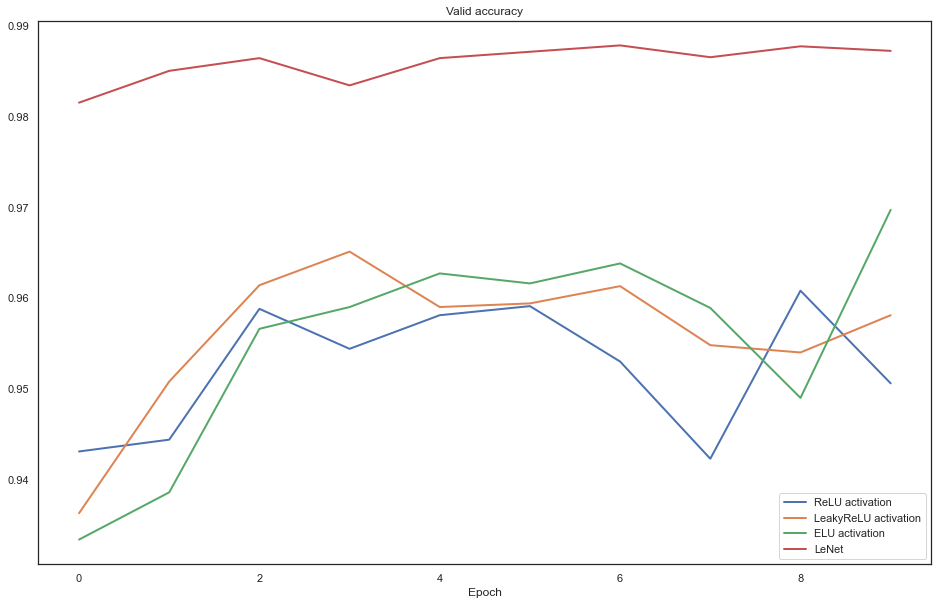

In [189]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99

In [190]:
lenet_accuracy[9]

0.9872